In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=40)
import sys
import math

In [3]:
import pywt

In [4]:
from SLIP import Image, imread
from LogGabor import LogGabor

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
def mnist_reshape_128(x, i_offset = 0, j_offset = 0):
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 - i_offset : 128 + 16 + 64 - i_offset, 128 + 16 - 64 - j_offset : 128 + 16 + 64 - j_offset]

In [7]:
def minmax(value,   #valeur a delimiter
           border): #limite min/max a ne pas depasser 
    value = max(value, -border)
    value = min(value, border)
    return value

def normalize(array):
    normalized_array = (array - np.mean(array)) / np.std(array)
    return normalized_array

## LogPolar transform

In [8]:
FIG_WIDTH = 12
FIGSIZE=(FIG_WIDTH, .618 * FIG_WIDTH)

In [9]:
param = {
# Image
'N_X' : 128, # size of images
'N_Y' : 128, # size of images
'do_mask'  : True, # used for instance in the Matching Pursuit algorithm self.pe.do_mask
'mask_exponent': 3., #sharpness of the mask
'use_cache' : True,
'verbose': 0,
'figpath': 'results',
'matpath': 'data_cache',
'datapath': 'database',
'figsize': 14.,
'formats': ['pdf', 'svg', 'jpg'],
'dpi': 450,
'seed': None, # a seed for the Random Number Generator (RNG) for picking images in databases, set to None or a given number to freeze the RNG
'N_image': None, # number of images to pick in a database, set to None if you want to pick all in the database
# whitening parameters:
'white_name_database' : 'kodakdb',
'white_n_learning' : 0,
'white_N' : .07,
'white_f_0' : .38, # olshausen = 0.2
'white_alpha' : 1.4,
'white_steepness' : 4.,
'white_recompute' : False,
}


In [10]:
i_offset = 10
j_offset = 10
N_X = 128
N_Y = 128

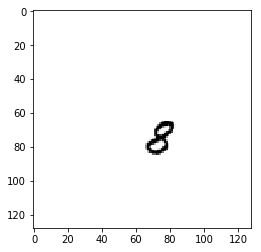

In [20]:
#im = Image(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
im = Image(pe=param)
#im = Image((128, 128))
mnist_sample_offset = mnist_reshape_128(mnist.train.images[5], i_offset = i_offset, j_offset = j_offset)
plt.imshow(mnist_sample_offset, cmap = 'gray_r')

In [21]:
image = mnist_sample_offset
print('Size of image', image.shape)

Size of image (128, 128)


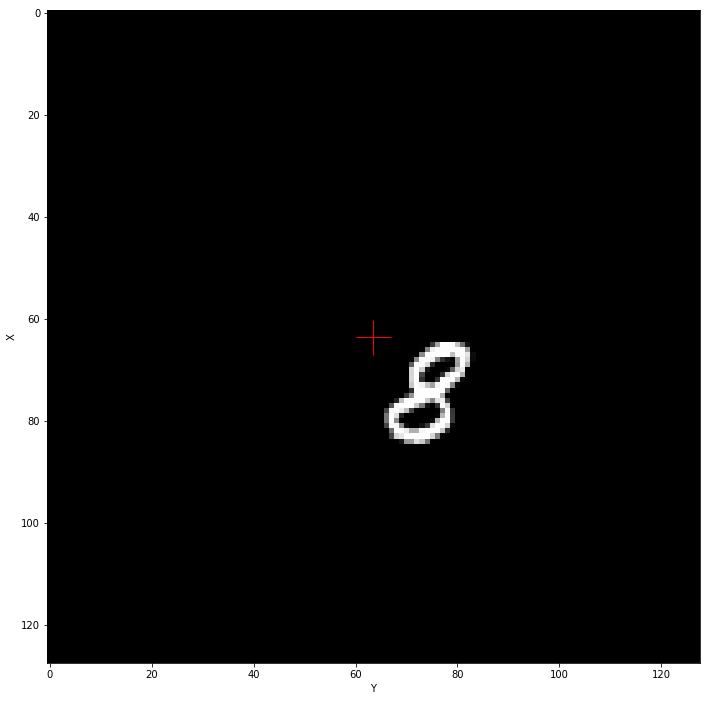

In [22]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image, cmap=plt.gray())
center = (63.5, 63.5) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

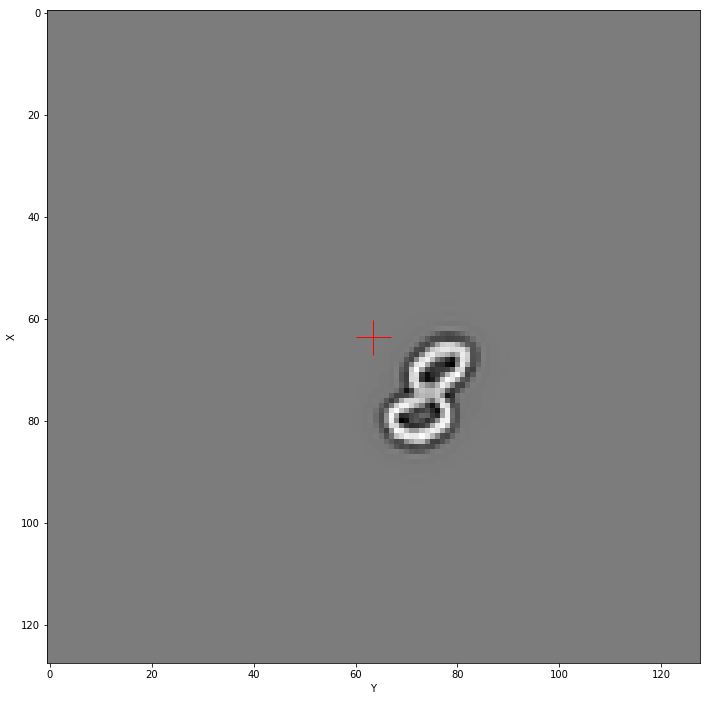

In [23]:
white = im.whitening(image)
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(white, cmap=plt.gray())
center = (63.5, 63.5) # X, Y
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot(center[1], center[0], 'r+', ms=35);

## LogGabor filters

In [11]:
parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))
params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
phase = np.pi/4
edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

## Vectorizing

In [ ]:
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            ecc =  .5**(N_scale - i_scale)
            r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
            sf_0 = 0.5 * 0.03 / ecc
            #print('radius=', r, 'at scale', i_scale, 'with sf_0=', sf_0 , 'ecc', ecc)
            x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
            y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
            for i_phase in range(N_phase):
                params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                #print('At', i_theta, i_orient, i_scale, i_phase, 'x, y=', x, y, 'params=', params)
                phase = i_phase * np.pi/2
                phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            env = np.sqrt(phi[i_theta, i_orient, i_scale, 0, :]**2 + phi[i_theta, i_orient, i_scale, 1, :]**2).reshape((N_X, N_Y))
            ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using phi')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout();

In [12]:
### Transformation en fonction
def vectorization(N_theta,
                  N_orient,
                  N_scale,
                  N_phase,
                  N_X,
                  N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

In [27]:
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
N_X, N_Y = 128, 128
vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)

array([[[[[  3.57078230e-08,   7.91535774e-07,  -7.52474000e-08, ...,
             7.29777127e-07,   1.37068341e-07,  -5.72618720e-07],
          [  6.96084624e-07,   4.63264280e-07,  -1.55741324e-07, ...,
             1.30862064e-06,   1.18025645e-07,  -8.38413886e-07]],

         [[ -7.09319960e-08,   8.92385337e-08,   8.14721466e-08, ...,
            -2.07336104e-08,   7.70514627e-08,   7.33337527e-08],
          [ -6.86092613e-09,   5.76349842e-08,  -8.61379693e-08, ...,
             3.69340082e-08,  -8.84492187e-08,   7.61246696e-08]],

         [[ -2.82947389e-08,  -2.63966209e-08,  -2.70289497e-08, ...,
            -3.59794948e-08,  -4.00599697e-08,  -4.21015279e-08],
          [ -6.49051490e-08,  -6.60466436e-08,  -6.83883434e-08, ...,
            -6.82459442e-08,  -6.72992698e-08,  -6.65156425e-08]],

         [[  1.04386118e-04,   1.07376619e-04,   1.09736113e-04, ...,
             1.21966455e-04,   1.25789991e-04,   1.28694249e-04],
          [  1.66135367e-04,   1.53732582e

## Example

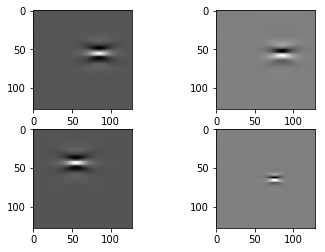

In [39]:
plt.subplot(2,2,1)
plt.imshow(np.reshape(phi[0,2,3,0,:],(128, 128))) # phi(N_theta, N_orient, N_scale, N_phase, ?)
plt.subplot(2,2,2)
plt.imshow(np.reshape(phi[0,2,3,1,:],(128, 128))) # phase inverse
plt.subplot(2,2,3)
plt.imshow(np.reshape(phi[0,4,3,0,:],(128,128))) # orientation modifiee
plt.subplot(2,2,4)
plt.imshow(np.reshape(phi[0,2,2,1,:],(128,128))) # echelle modifiee

## Encoding

In [28]:
code = phi @ image.ravel()
print('All scalar products in one shot = ', (code).shape )

All scalar products in one shot =  (6, 8, 5, 2)


In [29]:
print('Shape of phi=', phi.shape)
phi_vectorial = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
print('Shape of phi_vectorial=', phi_vectorial.shape)
print('Shape of phi=', phi_vectorial.reshape((N_theta, N_orient, N_scale, N_phase, N_X*N_Y)).shape)

Shape of phi= (6, 8, 5, 2, 16384)
Shape of phi_vectorial= (480, 16384)
Shape of phi= (6, 8, 5, 2, 16384)


In [30]:
vectorial_code = phi_vectorial @ image.ravel() # encoding x --> z 

In [31]:
print('Taille du code : ', vectorial_code.shape)

Taille du code :  (480,)


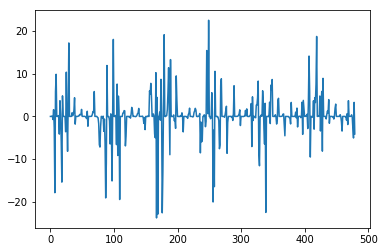

In [32]:
plt.plot(vectorial_code)

## Decoding / visualisation

In [33]:
phi_plus = np.linalg.pinv(phi_vectorial) # pseudo-inverse
image_hat = phi_plus @ vectorial_code # decoding z--> x

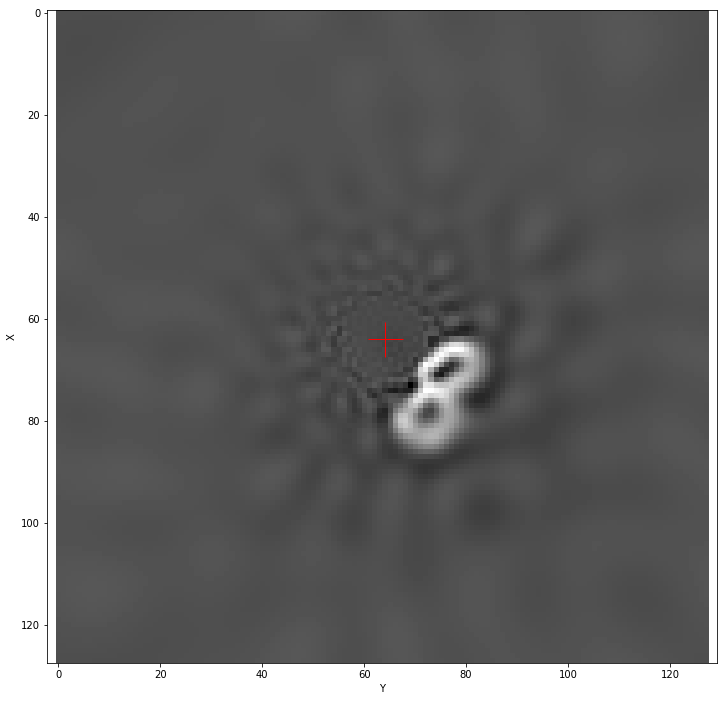

In [34]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
ax.imshow(image_hat.reshape((N_X, N_Y)), cmap=plt.gray())
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.plot([N_Y/2], [N_X/2], 'r+', ms=35)
ax.axis('equal');

## Energy

In [66]:
energy = (code**2).sum(axis=-1)
print('Shape of energy = ', energy.shape )

Shape of energy =  (6, 8, 5)


In [67]:
global_energy = (code**2).sum(axis=(0, -1))
print('Shape of global_energy = ', global_energy.shape )

Shape of global_energy =  (8, 5)


Shape of color_energy =  (8, 5, 3)


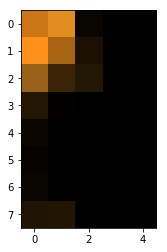

In [68]:
color_energy = np.zeros((N_orient, N_scale, 3))
for i_theta in range(N_theta):
    color = np.array([1 + np.cos(i_theta/N_theta + i*np.pi/3) for i in np.arange(3)])
    color_energy += energy[i_theta, :, :][:, :, np.newaxis] * color[np.newaxis, np.newaxis, :]
print('Shape of color_energy = ', color_energy.shape )
color_energy /= color_energy.max()
r, theta = np.meshgrid(np.linspace(0, 1, N_scale), np.linspace(0, 2*np.pi, N_orient))
fig, ax = plt.subplots()#subplot_kw=dict(projection='polar'))
#ax.pcolormesh(theta, r, color_energy);
ax.imshow(np.fliplr(color_energy));

In [69]:
log_r_target = 1  + np.log(np.sqrt(i_offset **2 + j_offset ** 2) / np.sqrt(N_X**2+N_Y**2) / 2) / 5
if j_offset != 0:
    theta_target = np.arctan(-i_offset / j_offset)
else:
    theta_target = np.sign(-i_offset) * np.pi/2


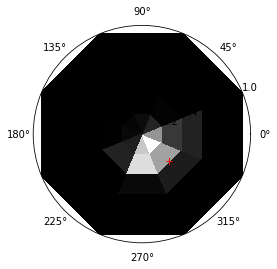

In [70]:
log_r, theta = np.meshgrid(np.linspace(0, 1, N_scale + 1), np.linspace(-np.pi * .625, np.pi * 1.375, N_orient + 1))
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.pcolor(theta, log_r, np.fliplr(global_energy))
#ax.plot(log_r_target * np.cos(theta_target), log_r_target * np.sin(theta_target), 'r+')
ax.plot(theta_target , log_r_target, 'r+')

# Modèle Détecteur+Classifier avec saccades oculaires (intégration TensorFlow)

In [70]:
sess = tf.Session()

### Définir les paramètres principaux

In [71]:
# Paramètres d'apprentissage
batch_size = 100
iterations = 10
alpha_detect = 0.0008
alpha_classif = 0.3

# Paramètre de la transformation logPolar
N_theta, N_orient, N_scale, N_phase = 6, 8, 5, 2
N_X, N_Y = 128, 128
phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
phi_vectorial = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))

## Programme principal

In [72]:
# Créer les placeholders et variables
x_train = tf.placeholder(tf.float32, shape=[None, 480], name='x_train')   # input (vector_data)

coord = tf.placeholder(tf.float32, shape=[None, 2], name='coord')         # labels (coordonnées)
weights_detect = tf.Variable(tf.zeros([480,2]), name='weights_detect')    # poids (coordonnées)

labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')      # labels (classes)
weights_classif = tf.Variable(tf.zeros([480,10]), name='weights_classif') # poids (classes)

#batch_phase = tf.placeholder(tf.bool, name='bn_phase')
# Initialiser les variables
init = tf.global_variables_initializer()
sess.run(init)

# Initialiser la sauvegarde du graph (variable + valeurs)
saver = tf.train.Saver()
    
# Calcul hypothèse du détecteur
hypo = tf.matmul(x_train, weights_detect)
#l2_regularizer = tf.contrib.layers.l2_regularizer(scale=0.5, scope=None)
#weights = [weights_detect,]
#hypo_bn = tf.contrib.layers.batch_norm(hypo, center=True, scale=True, is_training=batch_phase, scope='hypo', updates_collections=None)
# Définition du classifieur
classif = tf.nn.softmax(tf.matmul(x_train, weights_classif))

# Calcul coûts
cost_detect = (1/(2*batch_size))*(tf.reduce_sum(tf.square(hypo-coord))) #+ tf.contrib.layers.apply_regularization(l2_regularizer, weights)
cost_classif = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=classif)

# Lancer l'apprentissage
optimizer_detect = tf.train.GradientDescentOptimizer(alpha_detect).minimize(cost_detect) #AdamOptimizer(0.001)
optimizer_classif = tf.train.GradientDescentOptimizer(alpha_classif).minimize(cost_classif)

for it in range(iterations):
    print('iteration #', it)
    
    # Récupération des données d'apprentissage
    batch = mnist.test.next_batch(batch_size)
    
    #Entrainement détecteur
    values, coord_values = [], []
    num_x = 0
    for x in batch[0]:
        i_offset, j_offset = minmax(int(np.random.randn() * 15), 40), minmax(int(np.random.randn() * 15), 40)
        coord_values += [(i_offset, j_offset)]
        
        image = mnist_reshape_128(x, i_offset=i_offset, j_offset=j_offset)
        v = phi_vectorial @ np.ravel(image)
        values += [v]
        
        num_x += 1
        
    sess.run(optimizer_detect, {x_train: values, coord: coord_values}) #, batch_phase : True pour App
    print(weights_detect.eval(sess))
    
    # Entrainement classifier (images proches de la fovea)
    values, labels_values = [], []
    num_x = 0
    for x in batch[0]:
        i_offset, j_offset = minmax(int(np.random.randn() * 4), 4), minmax(int(np.random.randn() * 4), 4)
        labels_values += [batch[1][num_x]]
        
        image = mnist_reshape_128(x, i_offset=i_offset, j_offset=j_offset)
        v = phi_vectorial @ np.ravel(image)
        values += [v]
        
        num_x += 1
    
    sess.run(optimizer_classif, {x_train: values, labels: labels_values})
    
    # Sauvegarder le graph
    save_path = saver.save(sess, "/home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt")
    print("Model saved in file: %s" % save_path)

iteration # 0
[[  5.97298495e-05  -1.22968286e-05]
 [ -4.46311533e-05  -3.10649193e-05]
 [  4.17659030e-04   3.13300465e-04]
 ..., 
 [ -2.88031134e-03  -4.90552862e-04]
 [ -2.33913697e-02   1.53621910e-02]
 [ -1.26079628e-02   1.13653531e-02]]
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt
iteration # 1
[[  1.03858329e-05   1.41432956e-05]
 [ -9.49161695e-05   2.51842357e-06]
 [  4.41967946e-04   3.59987578e-04]
 ..., 
 [ -9.73736402e-04  -1.89218076e-03]
 [ -3.34164463e-02   1.68503840e-02]
 [  7.64555205e-03  -4.61519230e-03]]
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt
iteration # 2
[[  9.33290212e-05   2.46542586e-05]
 [ -1.53990841e-05  -4.32190200e-06]
 [ -3.19649436e-04   4.05177881e-04]
 ..., 
 [  3.07220384e-04  -2.59682257e-03]
 [ -4.89161015e-02   2.41194256e-02]
 [ -3.73388175e-03   1.49304355e-02]]
Model saved in file: /home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt
iteration # 3
[[  1.69875624e-04   1.964354

In [73]:
sess.close()

### Restaurer le graph enregistré

In [74]:
tf.reset_default_graph()
#weights_detect = tf.get_variable("weights_detect", shape=[480,2])
#saver = tf.train.Saver()

sess = tf.Session()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("/home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt.meta")
    saver.restore(sess, tf.train.latest_checkpoint('./'))

    print('weights_detect: \n' ,weights_detect.eval(sess)) # Imprimer les poids du classifier

INFO:tensorflow:Restoring parameters from /home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt


ValueError: Cannot use the given session to evaluate tensor: the tensor's graph is different from the session's graph.

## Intégration des saccades

### Définir les paramètres principaux

In [13]:
test_size = 3                                 # taille de l'echantillon de test
fovea_size = 4                                # longueur/largeur de la fovea

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "/home/pimt/Documents/Notebooks/TF_graph_logpolar.ckpt")
print("Model restored.")

ValueError: No variables to save

### Programme principal

In [56]:
test_batch = mnist.test.next_batch(test_size) # recuperation d'un echantillon de test

for x in test_batch[0]:
    target_not_in_fovea = True  # reste True tant que la cible n'est pas presente dans la fovea
    it = 1                      # nombre d'iterations ~= nombre de saccades
    previous_prediction = 0     # contient la prediction precedente lorsque it>0
    new_prediction = 0          # contient la nouvelle prediction lorsque it>0
   
    i_offset, j_offset = minmax(int(np.random.randn() * 15), 40), minmax(int(np.random.randn() * 15), 40)
    print('coord réelles', i_offset, j_offset)
    
    while target_not_in_fovea:
                
        image = mnist_reshape_128(x, i_offset=i_offset, j_offset=j_offset)
        v = phi_vectorial @ np.ravel(image)
        
        
        
        
        # Vérification position cible (est-elle présente dans la fovéa?)
        if  i_offset >= -(fovea_size/2) and i_offset <= (fovea_size/2):
            if j_offset >= -(fovea_size/2) and j_offset <= (fovea_size/2):
                target_not_in_fovea = False
                print('\n') # Séparation visuelle des outputs entre les essais
                break
        
        weights = weights_detect.eval(session=sess)
        coord_hat = np.dot(v, weights)    # prédiction des coordonnées par la modèle
        coord_hat = coord_hat.astype(int) # transformation de la prédiction en integer
        print('coord prédites', coord_hat)
                        
        if it != 1:   # si ce n'est pas la premiere iteration de la boucle while
            new_prediction = coord_hat + previous_prediction

        previous_prediction += coord_hat  # mise a jour de la prediction precedente 
        
        i_offset, j_offset = (i_offset - coord_hat[0]), (j_offset - coord_hat[1]) # nouvelle position de la cible par rapport au point de fixation apres saccade
        print('nouvelles coord', i_offset, j_offset)
        
        it += 1
        if it == 5:
            break # break de secours

coord réelles 34 -20


AttributeError: 'numpy.ndarray' object has no attribute 'eval'